# 이전 버전
# html에서 원하는 속성 추출하는 함수 만들기 (기사, 추출하려는 속성값)
def news_attrs_crawler(articles,attrs):
    attrs_content=[]
    for i in articles:
        attrs_content.append(i.attrs[attrs])
    return attrs_content

# ConnectionError방지
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/107.0.5304.107"}

#html생성해서 기사크롤링하는 함수 만들기(url): 링크를 반환
def articles_crawler(url):
    #html 불러오기
    original_html = requests.get(url,headers=headers)
    html = BeautifulSoup(original_html.text, "html.parser")
    url_naver = html.select("div.group_news > ul.list_news > li div.news_area > div.news_info > div.info_group > a.info")
    url = news_attrs_crawler(url_naver,'href')
    if len(url_naver) == 0:
        stop()
    return url
    
#제목, 링크, 내용 1차원 리스트로 꺼내는 함수 생성
def makeList(newlist, content):
    for i in content:
        for j in i:
            newlist.append(j)
    return newlist

#종료 함수
def stop():
    #데이터 프레임 저장
    #중복 행 지우기
    global raw_df
    raw_df = raw_df.drop_duplicates(keep='first',ignore_index=True)
    now = datetime.datetime.now()
    raw_df.to_csv(f'C:/Users/user/Foodinfo/data/news/{search_}_{start_date}_{end_date}.csv', encoding='utf-8-sig',index=False)
    sys.exit('정상적으로 처리되었습니다')
    
#####뉴스크롤링 시작#####
#검색어 입력
search_ = input("검색할 키워드를 입력해주세요:")
search = '"'+search_+'"' #정확하게 뉴스에 포함되는 경우만 가져오도록 "" 로 감싸기
#검색 시작할 날짜 입력
start_date = input("시작날짜: ")
S_Y = int(start_date[:4])
S_M = int(start_date[4:6])
S_D = int(start_date[6:])
s1 = datetime.date(S_Y,S_M,S_D).strftime("%Y.%m.%d")
s2 = datetime.date(S_Y,S_M,S_D).strftime("%Y%m%d")
#검색 종료할 날짜 입력
end_date = input("종료날짜: ")
E_Y = int(end_date[:4])
E_M = int(end_date[4:6])
E_D = int(end_date[6:])
e1 = datetime.date(E_Y,E_M,E_D).strftime("%Y.%m.%d")
e2 = datetime.date(E_Y,E_M,E_D).strftime("%Y%m%d")

if s1 > e1:
    print("시작날짜가 종료날보다 빠릅니다.")
    sys.exit()

# naver url 생성
page = 1
raw_df = pd.DataFrame(columns=['date','title','link','content', 'press'])
time_step = datetime.date(S_Y,S_M,S_D).strftime("%Y-%m-%d")
every_date = []
every_link = []
not_naver_urls = []
while True:
    url = f"https://search.naver.com/search.naver?where=news&sm=tab_pge&query={search}&sort=2&ds={s1}&de={e1}&nso=so:dd,p:from{s2}to{e2}&start={page}"
    
    #뉴스 크롤러 실행
    news_titles = []
    news_url =[]
    news_contents =[]
    news_press = []
    news_dates = []
    url = articles_crawler(url)
    news_url.append(url)

    #제목, 링크, 내용 담을 리스트 생성
    news_url_1 = []

    #1차원 리스트로 만들기(내용 제외)
    makeList(news_url_1,news_url)

    #NAVER 뉴스만 남기기
    final_urls = []
    every_link.extend(news_url_1)
    for i in range(len(news_url_1)):
        if "news.naver.com" in news_url_1[i]:
            final_urls.append(news_url_1[i])
        elif not "news.naver.com" in news_url_1[i]:
            not_naver_urls.append(news_url_1[i])
        else:
            pass
        
    # 뉴스 내용 크롤링
    for i in final_urls:
        #각 기사 html get하기
        news = requests.get(i,headers=headers)
        news_html = BeautifulSoup(news.text,"html.parser")

        # 뉴스 제목 가져오기
        title = news_html.select_one("#ct > div.media_end_head.go_trans > div.media_end_head_title > h2")
        if title == None:
            title = news_html.select_one("#content > div.end_ct > div > h2")

        # 뉴스 본문 가져오기
        content = news_html.select("div#dic_area")
        if content == []:
            content = news_html.select("#articeBody")

        # 기사 텍스트만 가져오기
        # list합치기
        content = ''.join(str(content))
        
        # 언론사명 가져오기
        try:
            press = news_html.select("#ct > div.media_end_head.go_trans > div.media_end_head_top > a > img.media_end_head_top_logo_img.light_type")[0]["title"]
        except:
            try:
                press = news_html.select("#content > div.end_ct > div > div.press_logo > a > img")[0]["alt"] #연합뉴스
            except:
                try:
                    press = news_html.select("#pressLogo > a > img")[0]['alt'] #스포츠서울
                except:
                    press = ''
                    
        # html태그제거 및 텍스트 다듬기
        pattern1 = '<[^>]*>'
        title = re.sub(pattern=pattern1, repl='', string=str(title))
        content = re.sub(pattern=pattern1, repl='', string=content)
        pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""
        content = content.replace(pattern2, '')
        news_titles.append(title)
        news_contents.append(content)
        news_press.append(press)
                
        try:
            html_date = news_html.select_one("div#ct> div.media_end_head.go_trans > div.media_end_head_info.nv_notrans > div.media_end_head_info_datestamp > div > span")
            news_date = html_date.attrs['data-date-time']
        except AttributeError:
            news_date = news_html.select_one("#content > div.end_ct > div > div.article_info > span > em")
            news_date = re.sub(pattern=pattern1,repl='',string=str(news_date))
        
        # 날짜 가져오기
        news_dates.append(news_date)
        every_date.extend(news_dates)
        # 진행날짜 표시
        if news_date[:10] != time_step:
                print(news_date[:10])
        time_step = news_date[:10]
        
    #데이터 프레임 만들기
    news_df = pd.DataFrame({'date':news_dates,'title':news_titles,'link':final_urls,'content':news_contents,'press':news_press})
    raw_df = pd.concat([raw_df, news_df])    

    page = page+10
    
    #400페이지 넘으면 오류 (향후 concat 하도록 수정 필요)
    if page == 4001:
        stop()
        
# 날짜 시리즈 생성
start = pd.to_datetime(start_date) ## 시작 날짜
end = pd.to_datetime(end_date) ## 마지막 날짜
dates = pd.date_range(start,end,freq='D') ## 일단위로 생성
dates = pd.DataFrame(data=dates, columns=['date']).astype('datetime64[ns]')
#dates = pd.DataFrame(raw_df['date'])

# 날짜별 뉴스 개수
from collections import Counter
day_list = []
for i in every_date:
    day_list.append(i[:10]) #시간빼고 날짜만 추출
count_items = Counter(day_list)

df_news_count = pd.DataFrame(data=[count_items.keys(),count_items.values()], index=['date', 'news_count']).T
date_none = df_news_count[df_news_count['date'] == 'None'] # 날짜를 가져오지 못해 None으로 표시된 값 개수
df_news_count = df_news_count.drop(date_none.index[0]) #NONE 있으면 삭제
df_news_count['date'] = df_news_count['date'].astype('datetime64[ns]')
df_news_count = pd.merge(dates, df_news_count, how='left').fillna(0)
#df_news_count = pd.concat([df_news_count, date_none], ignore_index=True) #일단은 제외. 어떻게 처리할지 고민
df_news_count.to_csv(f'C:/Users/user/Foodinfo/data/news/{search_}_{start_date}_{end_date}_news_count.csv', index=False)
df_news_count = pd.read_csv(f'C:/Users/user/Foodinfo/data/news/{search_}_{start_date}_{end_date}_news_count.csv')

df_news_count['date'] = df_news_count['date'].astype('datetime64[ns]')
df_news_count

# 그래프 생성
import matplotlib.pyplot as plt
# 한글 글씨체 설정
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.grid'] = False

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)
fig = plt.figure(figsize=(10,10)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
 
ax.plot(df_news_count['date'][:50],df_news_count['news_count'][:50]) ## 선그래프 생성
 
plt.xticks(rotation=45) ## x축 눈금 라벨 설정 - 40도 회전 
plt.title(f'{search_} 뉴스 개수',fontsize=20) ## 타이틀 설정
plt.show()

# 검색어와 상관분석
df__ = pd.read_csv('data/news/search_result_naver500_20221116.csv')
df__ = df__[df__['날짜'].isin(df_news_count['date'].astype('str').values)]
df__ = df__[['날짜',search_]].rename(columns={'날짜' : 'date'})
df__['date'] = df__['date'].astype('datetime64[ns]') #오류나면 이거 추가..

df_corr = pd.merge(df_news_count, df__, how='left', on='date')
df_corr.corr()

import seaborn as sns
sns.lmplot(x='news_count', y=search_, data=df_corr)

# 내용을 가져오지 않은 각 언론사별 뉴스 개수(추가 크롤러 작성 파악용)
- (https://hengbokhan.tistory.com/184)
#len(every_link) # 총 뉴스 수
#len(np.unique((not_naver_urls))) # 크롤링 안 된(네이버가 아닌 기사 수) -len+unique이면 종류만
count_items_press = Counter(not_naver_urls)
df_press_count = pd.DataFrame(data=[count_items_press.keys(),count_items_press.values()], index=['press', 'press_count']).T
df_press_count[df_press_count['press_count'] > 20] #20개 이상인 언론사

#언론사별 RSS데이터 (https://junpyopark.github.io/rss_parse/)
pd.read_pickle('C:/Users/user/Foodinfo/data/news/news_rss_list.pkl')

# 날짜로 추출 (자체 수정) -제목만 사용할거면 네이버기사만 추출하지 않아도 된다
- https://wonhwa.tistory.com/52

In [66]:
#크롤링시 필요한 라이브러리 불러오기
from bs4 import BeautifulSoup
import requests
import re
import datetime
from tqdm import tqdm
import sys
import pandas as pd

# html에서 원하는 속성 추출하는 함수 만들기 (기사, 추출하려는 속성값)
def news_attrs_crawler(articles,attrs):
    attrs_content=[]
    for i in articles:
        attrs_content.append(i.attrs[attrs])
    return attrs_content

#html생성해서 기사크롤링하는 함수 만들기(url): 링크를 반환
def articles_crawler(url):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/108.0.5359.95"}
    #html 불러오기
    original_html = requests.get(url,headers=headers)
    html = BeautifulSoup(original_html.text, "html.parser")
    url_naver = html.select("div.group_news > ul.list_news > li div.news_area > div.news_info > div.info_group > a.info")
    url = news_attrs_crawler(url_naver,'href')
    return url
    
#제목, 링크, 내용 1차원 리스트로 꺼내는 함수 생성
def makeList(newlist, content):
    for i in content:
        for j in i:
            newlist.append(j)
    return newlist

"""
#종료 함수
def stop(all_news_df, naver_news_df, search_, start_date, end_date):
    #중복 행 지우기
    all_news_df = all_news_df.drop_duplicates(keep='first',ignore_index=True)
    naver_news_df = naver_news_df.drop_duplicates(keep='first',ignore_index=True)
    #데이터 프레임 저장
    now = datetime.datetime.now()
    all_news_df.to_csv(f'./data/news_raw/title_{search_}_{start_date}_{end_date}.csv', encoding='utf-8-sig',index=False)
    naver_news_df.to_csv(f'./data/news_raw/naver_{search_}_{start_date}_{end_date}.csv', encoding='utf-8-sig',index=False)
    return sys.exit('정상적으로 처리되었습니다') #함수가 아니라면 break 실행하면 된다.
"""


# 모든 언론사의 '제목' 포함 크롤링
def all_news_crawler(url_):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/107.0.5304.107"}
    original_html = requests.get(url_,headers=headers)
    html = BeautifulSoup(original_html.text, "html.parser")
        
    # 뉴스 제목 가져오기
    url_news = html.select("a.news_tit")
    news_titles = news_attrs_crawler(url_news,'title')

    # 언론사명 가져오기(텍스트->언론사명만)
    url_news = html.select("div.info_group > a")
    news_press = list(map(lambda x: x.get_text(), url_news))
    news_press_ = list(map(lambda x: x.string, url_news))
    news_press = [x for x in news_press if x not in news_press_]
    
    # link 가져오기
    url_news = html.select("a.news_tit")
    news_urls = news_attrs_crawler(url_news,'href')
    
    # 날짜 가져오기(텍스트->날짜만)
    url_news = html.select("div.info_group > span")
    news_dates = list(map(lambda x: x.string, url_news))
    news_dates_ = list(map(lambda x: x.get_text(), url_news))
    news_dates = [x for x in news_dates if x in news_dates_]
    
    #00시간전/00일전 으로 뜨는 문제
    #현재시간-'00시간 전'이 양수면 오늘날짜로
    news_dates = list(map(lambda x: datetime.datetime.now().strftime("%Y.%m.%d") if ('시간 전' in x) and (datetime.datetime.now().hour >= int(x.split('시간')[0])) else x, news_dates))
    #현재시간-'00시간 전'이 음수면 어제날짜로.
    news_dates = list(map(lambda x: (datetime.datetime.now() - datetime.timedelta(hours=int(x.split('시간')[0]))).strftime("%Y.%m.%d") if ('시간 전' in x) and (datetime.datetime.now().hour <= int(x.split('시간')[0])) else x, news_dates))
    #'00일 전'이면 오늘날짜-00일만큼
    news_dates = list(map(lambda x: (datetime.datetime.now() - datetime.timedelta(days=int(x.split('일')[0]))).strftime("%Y.%m.%d") if '일 전' in x else x, news_dates))
    # 날짜 전처리       
    pattern = '([0-9]+)'
    news_dates = list(map(lambda x: re.findall(pattern=pattern, string=x), news_dates))
    news_dates = list(map(lambda x: '-'.join(x), news_dates))
        
    #데이터 프레임 만들기
    raw_df_all = pd.DataFrame({'date':news_dates,'title':news_titles,'link':news_urls,'press':news_press})
        
    return raw_df_all

# 네이버 뉴스의 '내용'포함 크롤링
def naver_news_crawler(naver_urls):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/107.0.5304.107"}
    naver_dates = []
    naver_titles = []
    naver_contents = []
    naver_press = []
    # 뉴스 본문내용 크롤링
    for i in naver_urls:
        #각 기사 html get하기
        news = requests.get(i,headers=headers)
        news_html = BeautifulSoup(news.text,"html.parser")

        # 뉴스 제목 가져오기
        title = news_html.select_one("#ct > div.media_end_head.go_trans > div.media_end_head_title > h2")
        if title == None:
            title = news_html.select_one("#content > div.end_ct > div > h2")

        # 뉴스 본문 가져오기
        content = news_html.select("div#dic_area")
        if content == []:
            content = news_html.select("#articeBody")

        # 기사 텍스트만 가져오기
        # list합치기
        content = ''.join(str(content))

        # 언론사명 가져오기
        try:
            press = news_html.select("#ct > div.media_end_head.go_trans > div.media_end_head_top > a > img.media_end_head_top_logo_img.light_type")[0]["title"]
        except:
            try:
                press = news_html.select("#content > div.end_ct > div > div.press_logo > a > img")[0]["alt"] #연합뉴스
            except:
                try:
                    press = news_html.select("#pressLogo > a > img")[0]['alt'] #스포츠서울
                except:
                    press = ''

        # html태그제거 및 텍스트 다듬기
        pattern1 = '<[^>]*>'
        title = re.sub(pattern=pattern1, repl='', string=str(title))
        content = re.sub(pattern=pattern1, repl='', string=content)
        pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""
        content = content.replace(pattern2, '')
        naver_titles.append(title)
        naver_contents.append(content)
        naver_press.append(press)
        
        # 뉴스 날짜 가져오기
        try:
            html_date = news_html.select_one("div#ct> div.media_end_head.go_trans > div.media_end_head_info.nv_notrans > div.media_end_head_info_datestamp > div > span")
            news_date = html_date.attrs['data-date-time']
        except AttributeError:
            news_date = news_html.select_one("#content > div.end_ct > div > div.article_info > span > em")
            news_date = re.sub(pattern=pattern1,repl='',string=str(news_date))
        
        
        # 날짜 전처리    
        pattern = '([0-9]+)'
        news_date = re.findall(pattern=pattern, string=news_date)
        news_date = '-'.join(news_date)

        #시간분초 삭제
        news_date = news_date[:10]
        #list(map(lambda x: str(x)[:10], news_date))
        
        # 날짜 가져오기
        naver_dates.append(news_date)
        
    #데이터 프레임 만들기
    raw_df_naver = pd.DataFrame({'date':naver_dates,'title':naver_titles,'link':naver_urls,'content':naver_contents,'press':naver_press})
    return raw_df_naver


# main함수
def Crawler(search_, start_date, end_date, recursive='No'): #재귀로 사용되는 경우라면 저장안 하도록 recursive 기본값 설정
    #####뉴스크롤링 시작#####
    #검색어 입력
    #search_ = input("검색할 키워드를 입력해주세요:")
    search = '"'+search_+'"' #정확하게 뉴스에 포함되는 경우만 가져오도록 "" 로 감싸기
    #검색 시작할 날짜 입력
    #start_date = input("시작날짜: ")
    S_Y = int(start_date[:4])
    S_M = int(start_date[4:6])
    S_D = int(start_date[6:])
    s1 = datetime.date(S_Y,S_M,S_D).strftime("%Y.%m.%d")
    s2 = datetime.date(S_Y,S_M,S_D).strftime("%Y%m%d")
    #검색 종료할 날짜 입력
    #end_date = input("종료날짜: ")
    E_Y = int(end_date[:4])
    E_M = int(end_date[4:6])
    E_D = int(end_date[6:])
    e1 = datetime.date(E_Y,E_M,E_D).strftime("%Y.%m.%d")
    e2 = datetime.date(E_Y,E_M,E_D).strftime("%Y%m%d")
    if s1 > e1: #input 일때만 남기기
        print("시작날짜가 종료날보다 빠릅니다.")
        sys.exit()

    # 크롤링한 데이터 축적을 위한 기본값 생성
    page = 1
    #global naver_news_df
    naver_news_df = pd.DataFrame(columns=['date','title','link','content', 'press']) #내용을 가져올 수 있는 '네이버뉴스'
    all_news_df = pd.DataFrame(columns=['date','title','link', 'press']) #내용을 가져오지 않고 제목만(모든 언론사)
    time_step = datetime.date(S_Y,S_M,S_D).strftime("%Y-%m-%d") #날짜 저장용
    every_date = []
    #every_url = []
    not_naver_urls = [] #본문내용을 추가로 가져올 크롤러 작성 용이함을 위해
    
    # url 생성
    while True:
        url_ = f"https://search.naver.com/search.naver?where=news&sm=tab_pge&query={search}&sort=2&ds={s1}&de={e1}&nso=so:dd,p:from{s2}to{e2}&start={page}"

        news_url = []
        url = articles_crawler(url_)
        news_url.append(url)
        
        #종료조건1
        if len(url) == 0: #stop(all_news_df, naver_news_df, search_, start_date, end_date)
            #중복 행 지우기
            all_news_df = all_news_df.drop_duplicates(keep='first',ignore_index=True)
            naver_news_df = naver_news_df.drop_duplicates(keep='first',ignore_index=True)
            #데이터 프레임 저장
            now = datetime.datetime.now()
            if recursive == 'No': #재귀함수로 다시 들어온 경우가 아니라면 저장실행
                all_news_df.to_csv(f'./data/news_raw/title_{search_}_{start_date}_{end_date}.csv', encoding='utf-8-sig',index=False)
                naver_news_df.to_csv(f'./data/news_raw/naver_{search_}_{start_date}_{end_date}.csv', encoding='utf-8-sig',index=False)
            return all_news_df, naver_news_df
        
        #모든 뉴스 크롤러 실행(모든 뉴스의 제목)
        raw_df_all = all_news_crawler(url_)
        all_news_df = pd.concat([all_news_df, raw_df_all])
        
        #제목, 링크, 내용 담을 리스트 생성
        news_url_1 = []

        #1차원 리스트로 만들기(내용 제외)
        makeList(news_url_1,news_url)
        
        #NAVER 뉴스만 남기기(내용을 가져올 수 있는 네이버 뉴스)
        naver_urls = []
        for i in range(len(news_url_1)):
            if "news.naver.com" in news_url_1[i]:
                not_naver_urls.append(news_url_1[i])
                naver_urls.append(news_url_1[i])
            elif not "news.naver.com" in news_url_1[i]:
                not_naver_urls.append(news_url_1[i])

        raw_df_naver = naver_news_crawler(naver_urls)
        naver_news_df = pd.concat([naver_news_df, raw_df_naver])
        
        # 진행날짜 표시
        if all_news_df['date'].values[-1] != time_step:
                print(all_news_df['date'].values[-1])
        time_step = all_news_df['date'].values[-1]        
        
        page = page+10

        #종료조건2
        if page == 4001:
            print('400페이지를 초과해 추가 크롤링을 진행합니다.')
            #400페이지 넘으면 재귀함수를 통해 합치기
            all_news_df2, naver_news_df2 = Crawler(search_, time_step.replace('-', ''), end_date, 'Yes')
            all_news_df = pd.concat([all_news_df, all_news_df2])
            naver_news_df = pd.concat([naver_news_df, naver_news_df2])
            #stop(all_news_df, naver_news_df, search_, start_date, end_date)
            #중복 행 지우기
            all_news_df = all_news_df.drop_duplicates(keep='first',ignore_index=True)
            naver_news_df = naver_news_df.drop_duplicates(keep='first',ignore_index=True)
            #데이터 프레임 저장
            now = datetime.datetime.now()
            all_news_df.to_csv(f'./data/news_raw/title_{search_}_{start_date}_{end_date}.csv', encoding='utf-8-sig',index=False)
            naver_news_df.to_csv(f'./data/news_raw/naver_{search_}_{start_date}_{end_date}.csv', encoding='utf-8-sig',index=False)
            return all_news_df, naver_news_df

In [68]:
all_news_df, naver_news_df = Crawler('식품안전나라', '20160101', '20221231')

2022-01-05
2022-01-06
2022-01-14
2022-01-19
2022-01-27
2022-01-31
2022-02-06
2022-02-08
2022-02-09
2022-02-17
2022-02-21
2022-02-22
2022-03-02
2022-03-03
2022-03-04
2022-03-17
2022-03-18
2022-03-21
2022-03-25
2022-03-30
2022-03-31
2022-04-06
2022-04-11
2022-04-12
2022-04-20
2022-04-21
2022-04-22
2022-04-24
2022-04-25
2022-04-27
2022-04-28
2022-05-03
2022-05-08
2022-05-11
2022-05-12
2022-05-16
2022-05-26
2022-05-29
2022-05-31
2022-06-01
2022-06-02
2022-06-09
2022-06-15
2022-06-21
2022-06-28
2022-07-07
2022-07-14
2022-07-15
2022-07-28
2022-08-10
2022-08-17
2022-08-23
2022-08-24
2022-08-30
2022-09-07
2022-09-09
2022-09-16
2022-09-30
2022-10-04
2022-10-12
2022-10-17
2022-10-24
2022-10-25
2022-11-04
2022-11-09
2022-11-10
2022-11-11
2022-11-17
2022-11-23
2022-11-27
2022-11-30
2022-12-01
2022-12-13
2022-12-14
2022-12-20
2022-12-21
2022-12-23
2022-12-28
2022-12-31


# 날짜별 뉴스 개수

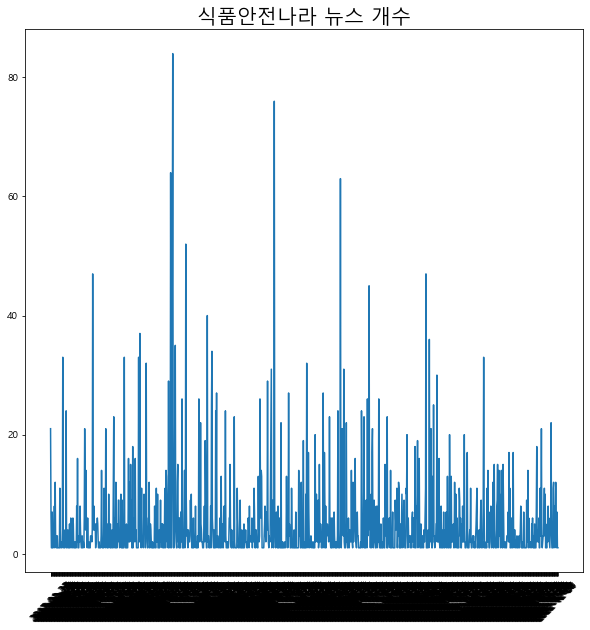

In [75]:
search_ = '식품안전나라'
df_ = pd.read_csv('data/news_raw/title_식품안전나라_20160101_20221231.csv').rename(columns={'title':'news_count'})

# 그래프 생성
import matplotlib.pyplot as plt
# 한글 글씨체 설정
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.grid'] = False

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)
fig = plt.figure(figsize=(10,10)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
df_count = df_.groupby(['date'])['news_count'].count()
ax.plot(df_count.keys(), df_count.values) ## 선그래프 생성

plt.xticks(rotation=45) ## x축 눈금 라벨 설정 - 40도 회전 
plt.title(f'{search_} 뉴스 개수',fontsize=20) ## 타이틀 설정
plt.show()

# 검색어와 상관분석

            news_count    식품안전나라
news_count    1.000000  0.385482
식품안전나라        0.385482  1.000000


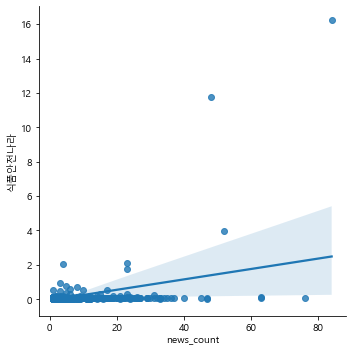

In [7]:
# 검색어와 상관분석
df__ = pd.read_csv('data/news/search_result.csv')
df__ = df__[df__['날짜'].isin(df_count.keys())]
df__ = df__[['날짜',search_]].rename(columns={'날짜' : 'date'})
#df__ = df__[]
#df__['date'] = df__['date'].astype('datetime64[ns]') #오류나면 이거 추가..

df_corr = pd.merge(df_count, df__, how='left', on='date')
print(df_corr.corr())

import seaborn as sns
sns.lmplot(x='news_count', y=search_, data=df_corr)

# 최근 한달의 뉴스량
- https://yenpa.tistory.com/m/6

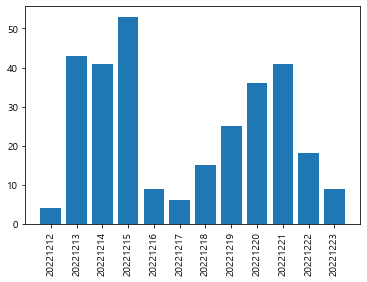

,title
Date,
20221212,4
20221213,43
20221214,41
20221215,53
20221216,9
20221217,6
20221218,15
20221219,25
20221220,36


In [8]:
import os
import sys
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt

client_id = "개인 API"
client_secret = "개인 API"
display=100
start=1
#sort='sim'
sort='date'

def getresult(client_id,client_secret,search_,display=10,start=1,sort='sim'):
    encText = urllib.parse.quote(search_)
    url = "https://openapi.naver.com/v1/search/news?query=" + encText + \
    "&display=" + str(display) + "&start=" + str(start) + "&sort=" + sort

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if(rescode==200):
        response_body = response.read()
        response_json = json.loads(response_body)
    else:
        print("Error Code:" + rescode)

    return pd.DataFrame(response_json['items'])

result_all=pd.DataFrame()
for i in range(0,3):
    start= 1 + 100*i
    result= getresult(client_id,client_secret,search_,display,start,sort)
    
    result_all=pd.concat([result_all,result])
    
result_all=result_all.reset_index() # index가 100단위로 중복되는것을 초기화
result_all=result_all.drop('index',axis=1) # reset_index후 생기는 이전 index의 column을 삭제
result_all['pubDate']=result_all['pubDate'].astype('datetime64[ns]') # pubDate의 타입을 object에서 datetime으로 변경
result_all['Date'] = result_all['pubDate'].dt.strftime('%Y%m%d')#날짜별 집계를 위해 'YYYYmmdd' 타입의 column을 생성

result_gr=result_all[['Date','title']].groupby(['Date']).count()

plt.bar(result_gr.index,result_gr['title'])
plt.xticks(rotation=90)
plt.show()
result_gr

# 네이버 랭킹 뉴스
- https://velog.io/@hyunsuki/Personal-Project-%EB%85%BC%EB%AC%B8%EC%A0%9C%EB%AA%A9-%EB%B6%84%EC%84%9D%EC%9D%84-%ED%86%B5%ED%95%9C-%EC%84%A0%ED%96%89%EC%97%B0%EA%B5%AC-%EB%B6%84%EC%84%9DKeyword%EB%A5%BC-%EC%A4%91%EC%8B%AC%EC%9C%BC%EB%A1%9C

In [1]:
#-https://mons1220.tistory.com/241
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd
import numpy as np
import re


""" 네이버 랭킹 뉴스 긁어오기 """
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36'}

d_list = []
start_data = 20210101
end_data = 20210116
for date_int in range(start_data, end_data):
    date = str(date_int)
    url = "https://news.naver.com/main/ranking/popularDay.nhn?date=" + date
    html = requests.get(url, headers=headers).text
    soup = BS(html, 'html.parser')
    ranking_total = soup.find_all(class_='rankingnews_box')

    for item in ranking_total:
        media = item.a.strong.text
        news = item.find_all(class_="list_content")
        for new in news:
            d = {}
            d['media'] = media
            d['src'] = "https://news.naver.com/" + new.a['href']
            d['title'] = new.a.text
            d['date'] = date
            d_list.append(d)
df = pd.DataFrame(d_list)

In [2]:
df

,media,src,title,date
0,노컷뉴스,https://news.naver.com/https://n.news.naver.co...,성탄절에 숨진 응급구조사…12시간 폭행·괴롭힘에 CCTV도 지워져,20210101
1,노컷뉴스,https://news.naver.com/https://n.news.naver.co...,"모더나도 계약…정은경 ""내년은 백신으로 코로나 대응 준비""",20210101
2,노컷뉴스,https://news.naver.com/https://n.news.naver.co...,승객 성폭행하려다 택시 뺏긴 기사…징역 3년에 항소,20210101
3,노컷뉴스,https://news.naver.com/https://n.news.naver.co...,"이낙연 ""이명박·박근혜 사면 건의할 것""(종합)",20210101
4,노컷뉴스,https://news.naver.com/https://n.news.naver.co...,최악 치달은 동부구치소發 집단감염…법무부 뒷북대응 '도마',20210101
...,...,...,...,...
5301,레이디경향,https://news.naver.com/https://n.news.naver.co...,[백인혜의 SNS 톡톡] 인간 본능 취향저격 트렌드 ‘할메니얼’,20210115
5302,레이디경향,https://news.naver.com/https://n.news.naver.co...,호텔업계 2021 키워드 ‘안전’···힐링은 '덤',20210115
5303,레이디경향,https://news.naver.com/https://n.news.naver.co...,"[임성용의 보약밥상] 굴, 어디에 좋을까?",20210115
5304,레이디경향,https://news.naver.com/https://n.news.naver.co...,"[주바리의 까칠한 味수다] '집콕 시대' 배달의 맛집, 배슐랭 가이드를 알려주마",20210115


# 뉴스 지역 시각화
- https://foss4g.tistory.com/1409